In [232]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power
from datetime import timedelta
def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [318]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### Задание 3
**Срок сдачи: 07 апреля 18:00**

В этом задание вы будете работать с выручкой - метрикой с достаточно высокой дисперсией и соответсвенно низкой чувствительностью к изменениям.

Вам предстоит разработать подход по повышению чувствительности этой метрики.
От успеха данной инициативы зависит то, как быстро мы сможем проверять продуктовые гипотезы.

#### Для планирования эксперимента изучите данные и метрики 2 балла:

- Загрузите файл и изучите данные;
- Изучите основные статистики метрики: среднее, стандартное отклонение;
- Изучите то, как эти статистики изменяются внутри срезов: user_segment, region, category

#### Предскажите минимально детектируемый эффект (MDE) 2 балла:

- Для размеров тестовых групп 10,25,50% и длительностей 30, 60, 90 дней предскажите минимально детектируемый эффект;


#### CUPED 6 баллов
Разработайте подход по снижению дисперсии на основе методики CUPED:

- Рассчитайте CUPED метрику на основе данных за периода в 30 дней перед предполагаемым периодом сбора основной выборки и опишите как изменился MDE для выборок 50/50%, собранных за 30 дней (2 бала). 
- Проверьте насколько данный подход подвержен сезональности. Как меняется MDE, если применять данный подход в разные периоды (2 бала). 
- Оптимизируйте подход варьируя количество дней до теста, которые вы будете для расчёта CUPED метрики. Какое максимальное снижение MDE вы смогли достичь (2 бала).



#### * Стратификация 4 балла (задание для получения дополнительных баллов)
Разработайте подход по снижению дисперсии на основе методики стратификации выборок:

- Стратифицируйте выборки внутри срезов user_segment, region, category
- Рассчитайте стратифицированные среднее,стандартное отклонение для этих выборок и MDE для теста 50/50% длительностью 30 дней.
- В каких срезах достигается наибольшее снижение MDE?



#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

user_segment - сегмент пользователей

region - регион

category - категория авито

revenue_amount - сумма покупок


In [246]:
df = pd.read_csv('user_amount_var_reduction.csv')
df['event_date']=df.event_date.apply(date_converter)

### <b>1. Общая информация

In [247]:
df.head()

,event_date,user_id,user_segment,category,region,revenue_amount
0,2019-06-18,4129257975403696,4626944681007198896,7204754148424990691,2201388710798473628,139
1,2019-06-18,7225254357470025,4626944681007198896,57514010642945023,3048517866726460689,193
2,2019-06-18,8912846500600569,4626944681007198896,5983323600580891431,3048517866726460689,160
3,2019-06-18,20910801279823046,4626944681007198896,6847326422676498281,7762196236856042106,209
4,2019-06-18,34873300821657220,2376074197230840906,3187769798308634693,3855810523611026650,160


In [52]:
df['weekday'] = pd.DatetimeIndex(df['date']).weekday
df['week'] = df['date'].dt.isocalendar().week

In [250]:
df.columns = ['date', 'user_id', 'segment', 'category', 'region', 'revenue']

In [251]:
df[['segment', 'category', 'region']]=df[['segment', 'category', 'region']].astype('str')

In [252]:
df.info()
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8625842 entries, 0 to 8625841
Data columns (total 6 columns):
 #   Column    Dtype         
---  ------    -----         
 0   date      datetime64[ns]
 1   user_id   int64         
 2   segment   object        
 3   category  object        
 4   region    object        
 5   revenue   int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 394.9+ MB


0

In [253]:
df.nunique()

date            175
user_id     1932049
segment           3
category         33
region           84
revenue       15357
dtype: int64

In [255]:
df.date.min(), df.date.max()

(Timestamp('2019-06-18 00:00:00'), Timestamp('2019-12-09 00:00:00'))

In [256]:
df.segment.unique()

array(['4626944681007198896', '2376074197230840906', '853431062533847667'],
      dtype=object)

### <b> 2. Подготовка данных

In [257]:
def line_plot(data, x=None, y=None, hue=None, title=None):
    # Функция рисует линейный график по данным data
    plt.figure(figsize=(16, 9))
    ax = sns.lineplot(y=y, x=x,  data=data, hue=hue)
    ax.set_title(title)
    plt.show()
    
def count_plot(data, x=None, y=None, hue=None, title=None):    
    plt.figure(figsize=(16, 9))
    ax = sns.countplot(x=x, hue=hue, data=data, dodge=False, alpha=0.3)
    ax.set_title(title)
    plt.show()

In [266]:
dfg_dates = df.groupby(['date', 'category', 'segment'])[['user_id', 'revenue']].agg({'user_id':'count', 'revenue': np.sum}).reset_index(drop=False)
dfg_dates['weekday'] = pd.DatetimeIndex(dfg_dates['date']).weekday
dfg_dates['week'] = dfg_dates['date'].dt.isocalendar().week
dfg_dates.rename(columns={"user_id": "count"}, inplace=True)
dfg_dates.fillna(0, inplace=True)


In [267]:
dfg_dates.tail()

,date,category,segment,count,revenue,weekday,week
16148,2019-12-08,7948270325129383019,853431062533847667,490,500969,6,49
16149,2019-12-08,91460430793700892,2376074197230840906,173,75628,6,49
16150,2019-12-08,91460430793700892,4626944681007198896,721,193451,6,49
16151,2019-12-08,91460430793700892,853431062533847667,56,41685,6,49
16152,2019-12-09,1472231361867825698,4626944681007198896,1,91,0,50


In [268]:
dfg_dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16153 entries, 0 to 16152
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      16153 non-null  datetime64[ns]
 1   category  16153 non-null  object        
 2   segment   16153 non-null  object        
 3   count     16153 non-null  int64         
 4   revenue   16153 non-null  int64         
 5   weekday   16153 non-null  int64         
 6   week      16153 non-null  UInt32        
dtypes: UInt32(1), datetime64[ns](1), int64(3), object(2)
memory usage: 836.2+ KB


In [269]:
dfg_dates.nunique()

date          175
category       33
segment         3
count        2544
revenue     15134
weekday         7
week           26
dtype: int64

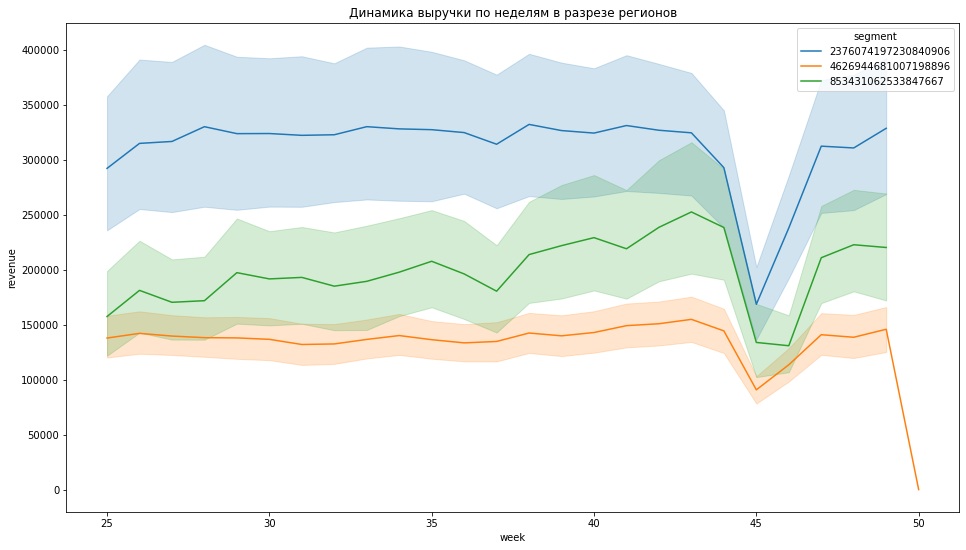

In [271]:
# Посмотрим на распределение динамику прибыли 
line_plot(y=dfg_dates.revenue, 
          x=dfg_dates.week,  
          data=dfg_dates, 
          hue='segment', 
          title='Динамика выручки по неделям в разрезе регионов')

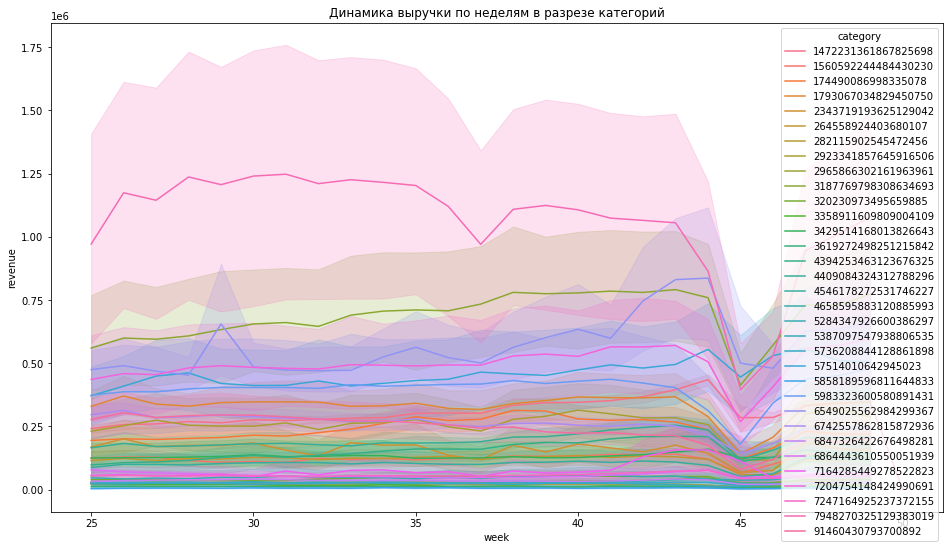

In [273]:
# Посмотрим на динамику прибыли по категориям
line_plot(y=dfg_dates.revenue, 
          x=dfg_dates.week,  
          data=dfg_dates, 
          hue='category', 
          title='Динамика выручки по неделям в разрезе категорий')

Наблюдаем равномерную динамику выручки по неделям за исключением периода в начале ноября. Можно предположить, что это связано со сбоем в приложении. 
Также присутствует сильная недельная сезонность

In [277]:
dfg = df.groupby(['category', 'region', 'segment'])[['user_id', 'revenue']].agg({'user_id':'count', 'revenue': np.mean}).reset_index(drop=False)
dfg.rename(columns={"user_id": "count"}, inplace=True)
dfg.head()

,category,region,segment,count,revenue
0,1472231361867825698,1046676874565143364,2376074197230840906,1163,174.700774
1,1472231361867825698,1046676874565143364,4626944681007198896,3370,97.298813
2,1472231361867825698,1046676874565143364,853431062533847667,197,667.741117
3,1472231361867825698,1103602596183811891,2376074197230840906,19,69.315789
4,1472231361867825698,1103602596183811891,4626944681007198896,471,102.883227


<AxesSubplot:xlabel='count', ylabel='revenue'>

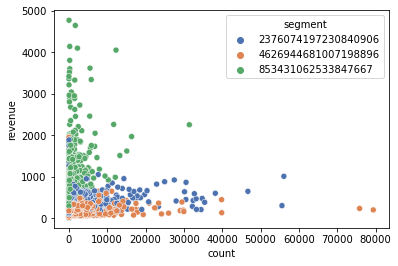

In [279]:
sns.scatterplot(data=dfg, y='revenue', x="count", hue="segment", palette="deep")

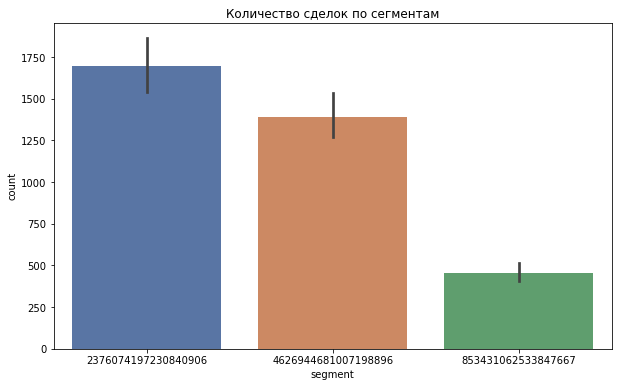

In [282]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=dfg, y='count', x="segment", palette="deep")
ax.set_title('Количество сделок по сегментам')
plt.show()

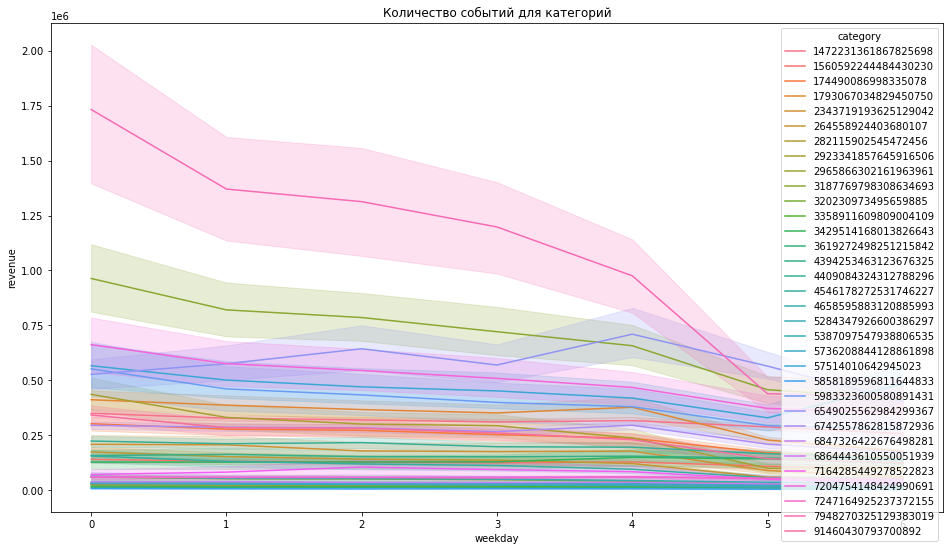

In [283]:
# Посмотрим на распределение прибыли по дням недели
line_plot(y=dfg_dates.revenue, x=dfg_dates.weekday,  data=dfg_dates, hue='category', title='Количество событий для категорий')

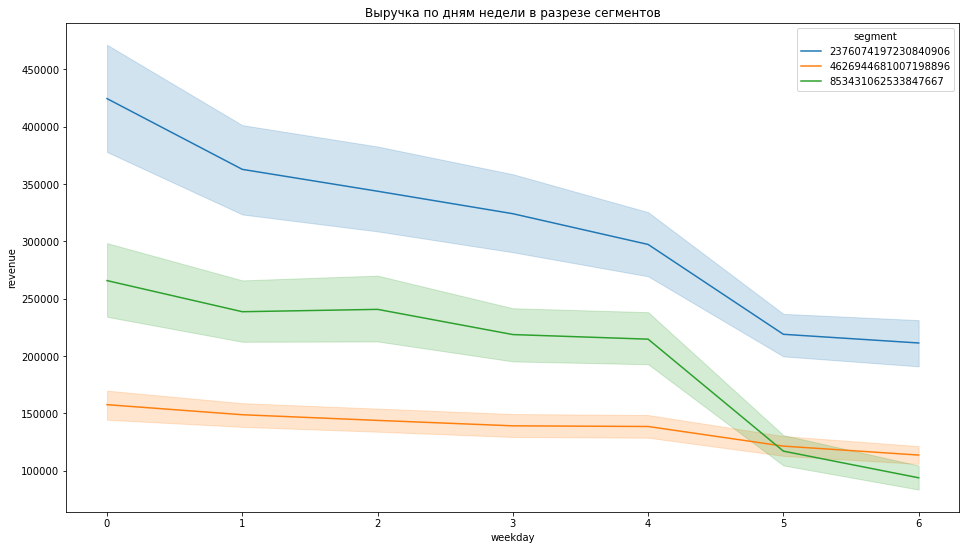

In [285]:
# Посмотрим на распределение прибыли по дням недели
line_plot(y=dfg_dates.revenue, 
          x=dfg_dates.weekday,  
          data=dfg_dates, 
          hue='segment', 
          title='Выручка по дням недели в разрезе сегментов')

Основная выручка приходится на будние дни

In [308]:
def calc_stsc(df, col):
    temp = df.groupby([col, 'user_id'])[['revenue']].agg([np.sum]).reset_index(drop=False)
    temp= temp.groupby([col])[[('revenue', 'sum')]].agg([np.mean, np.std]).reset_index(drop=False)
    temp.columns = [col, 'mean', 'std']
    return temp

In [311]:
stat={}
for col in ['category', 'region', 'segment']:
    stat[col] = calc_stsc(df, col)

In [319]:
stat['segment'].head()
stat['region'].head()
stat['category'].head()

,segment,mean,std
0,2376074197230840906,2493.691418,9820.731918
1,4626944681007198896,519.322613,1577.740638
2,853431062533847667,48775.231909,164513.128251


,region,mean,std
0,1046676874565143364,1296.755094,8959.943741
1,1103602596183811891,611.899168,2878.749072
2,1116465816370945844,1716.071246,11618.146052
3,1187552825302355021,705.172376,3057.408560
4,1282872640859057241,1059.006608,6146.516254


,category,mean,std
0,1472231361867825698,679.799879,9038.733455
1,1560592244484430230,834.321764,4359.805621
2,174490086998335078,825.001697,8233.668747
3,1793067034829450750,1756.367168,14685.563176
4,2343719193625129042,4687.107884,26156.828325


Средняя прибыль по категориям, сегментам и регионам сильно отличается. Стандартное отклонение также сильно колеблется

**Предскажите минимально детектируемый эффект (MDE) 2 балла:**
<br>Для размеров тестовых групп 10,25,50% и длительностей 30, 60, 90 дней предскажите минимально детектируемый эффект;

In [320]:
def calc_nobs(df, share=0.5, days=90):
    start_day = df.date.min()
    end_day = start_day + timedelta(days)
    nobs = int(df[(df.date >= start_day) & (df.date <= end_day)].user_id.nunique() * share / 2)
    return nobs

In [341]:
# Посчитаем mde для разных параметров share и количества дней теста
df_std = df.groupby(['user_id'])[['revenue']].agg([np.sum]).reset_index(drop=False)
mean = df_std.mean()[('revenue', 'sum')]
std = df_std.std()[('revenue', 'sum')]
alpha = 0.01
power = 0.8
share_list = [0.1, 0.25, 0.5]
days = [30, 60, 90]

In [343]:
predict = []
for share in share_list:
    for n in days:
        nobs = calc_nobs(df, share=share, days=n)
        mde = tt_ind_solve_power(alpha=alpha, power=power, nobs1=nobs)
        predict.append([share, n, mde*std])
predict   

[[0.1, 30, 535.8884876394075],
 [0.1, 60, 432.00707479236036],
 [0.1, 90, 377.4149484530536],
 [0.25, 30, 338.93484165543043],
 [0.25, 60, 273.1902547294677],
 [0.25, 90, 238.69421201682417],
 [0.5, 30, 239.66133473158692],
 [0.5, 60, 193.17703525622665],
 [0.5, 90, 168.78259163830998]]

In [344]:
# Средняя выручка
mean

1789.8822597149451

In [349]:
df_std[('revenue', 'sum')].median()

245.0

In [347]:
df_std.head()

,user_id,revenue
,,sum
0,702221222224,356
1,1336907904656,1321
2,1912219714366,1085
3,4358074930207,167
4,7562887359106,244


В лучшем случае при проведении теста на 50% пользователей мы можем расчитывать на минимальный детектируемый эффект не менее 168 (руб.?), так как выручка получается слишком шумная метрика.